**Table of contents**<a id='toc0_'></a>    
- 1. [Measure synchronization of tremor in Alaska](#toc1_)    
- 2. [Load data](#toc2_)    
- 3. [Measure correlation distance](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>Measure synchronization of tremor in Alaska [&#128285;](#toc0_)

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
import sys
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    sys.path.append('/home/gafarge/py_modules/my_modules')
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    sys.path.append('/Users/gaspard/Documents/work/py_modules/my_modules')
    workdir = '/Users/gaspard/Documents/work/'
from stats import cross_corr

In [16]:
mag_min = 2.4


# 2. <a id='toc2_'></a>Load data [&#128285;](#toc0_)

In [17]:
day0 = np.datetime64('2013-01-01')

In [18]:
# Tremor data
trm = pd.read_csv('data/alaska/processed/ak_trm_0113_1015_zslab2_eqdist_mc{:.1f}.csv'.format(mag_min), parse_dates=['date'])
trm['day'] = (trm.date - day0) / np.timedelta64(1, 'D')

In [19]:
# Earthquake data
eq = pd.read_csv('data/alaska/processed/ak_eqmc{:.1f}_0113_1015_eqdist.csv'.format(mag_min))

strip = lambda x: str.removesuffix(x, '+00:00')
eq['date'] = list(map(strip, eq.date))
eq['date'] = pd.to_datetime(eq.date, format='mixed')

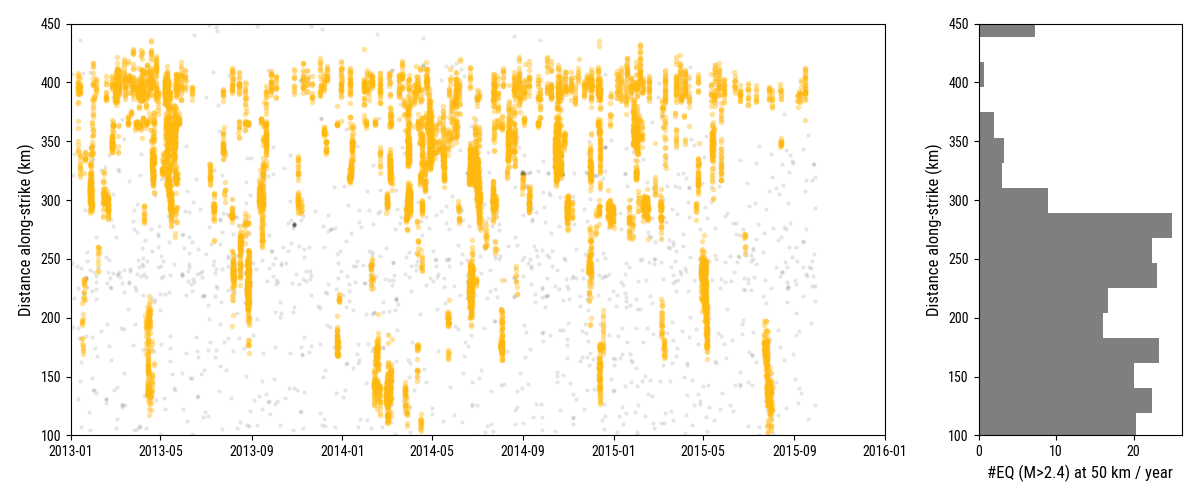

In [20]:
# Overview
dist = 50

fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1])

# Activity in time and space
ax = fig.add_subplot(gs[0])
ax.set_xlim(np.datetime64('2013-01-01'), np.datetime64('2016-01-01'))
ax.set_ylim(100, 450)
ax.set_ylabel('Distance along-strike (km)')
ax.plot(trm.date, trm.xf, 'o', c=to_rgba('C2', .4), mec=[0,0,0,0], ms=4)
ax.plot(eq.date, eq.xf, 'o', c=to_rgba('k', .1), mec=[0,0,0,0], ms=3, zorder=0)

# Number of earthquakes
ax = fig.add_subplot(gs[1], sharey=ax)
ax.set_xlabel('#EQ (M>{:.1f}) at {:d} km / year'.format(mag_min, dist))
ax.set_ylabel('Distance along-strike (km)')
ax.hist(eq.xf[eq['in{:d}km'.format(dist)]], weights=np.ones(len(eq.xf[eq['in{:d}km'.format(dist)]]))/3, bins=20, orientation='horizontal', color='k', alpha=.5)

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Measure correlation distance [&#128285;](#toc0_)

In [21]:
# Make the matrix of cross-correlation — Parameters
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 100
xmax_bin = 450
x_bin_edges = np.arange(xmin_bin, xmax_bin + dx_bin, dx_bin)

# --> Parameters for the temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

In [22]:
# Make the matrix of cross-correlation — Computation (takes time, 30s for bins of 10 km, 1 day, 1000 km wide)
# --> Make the counts
count_time = np.arange(0, trm.day.max()+delta, delta)
counts = np.zeros((len(x_bin_edges)-1, len(count_time)-1))

for ii in range(len(x_bin_edges)-1):
    x_min = x_bin_edges[ii]
    x_max = x_bin_edges[ii+1]
    trm_in_bin = trm.xf.between(x_min, x_max)
    counts[ii, :] = np.histogram(trm[trm_in_bin].day.values, bins=count_time)[0]

# --> Compute the cross-correlation matrix
cc_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))
lag_matrix = np.zeros((len(x_bin_edges)-1, len(x_bin_edges)-1))

for ii in range(len(x_bin_edges)-1):
    for jj in range(len(x_bin_edges)-1):
        if jj <= ii:
            if ~np.any(counts[ii, :]) or ~np.any(counts[jj, :]):
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.nan
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = np.nan
            else:
                cc, lag = cross_corr(counts[ii, :], counts[jj, :], delta, norm=norm, no_bias=no_bias)
                
                if look_both_ways:
                    cc = (cc + cc[::-1]) / 2
                    cc = cc[lag >= 0]
                    lag = lag[lag >= 0]
                
                in_window = np.abs(lag) <= abs((x_bin_edges[ii+1] + x_bin_edges[ii])/2 - (x_bin_edges[jj+1] + x_bin_edges[jj])/2) / v_min
                cc_matrix[ii, jj] = cc_matrix[jj, ii] = np.max(cc[in_window])
                lag_matrix[ii, jj] = lag_matrix[jj, ii] = lag[in_window][np.argmax(cc[in_window])]

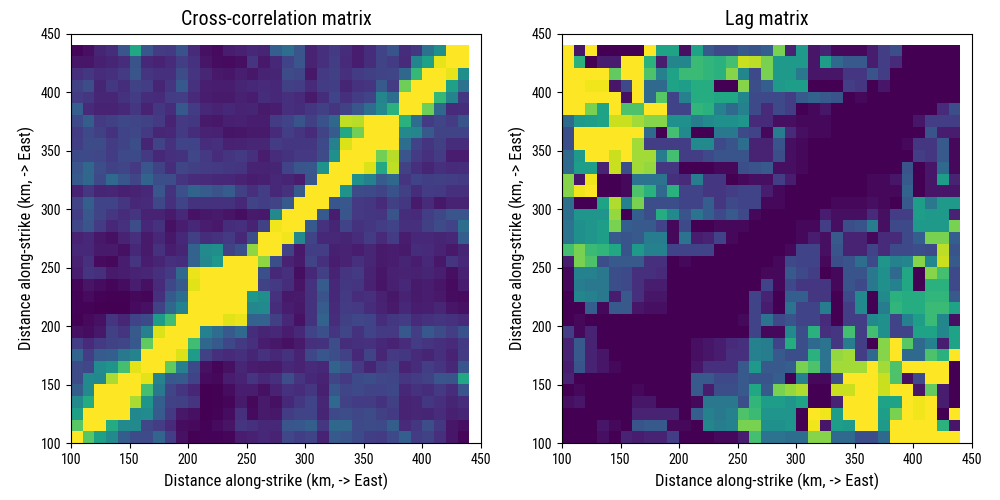

In [23]:
# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> East)')
ax.set_ylabel('Distance along-strike (km, -> East)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

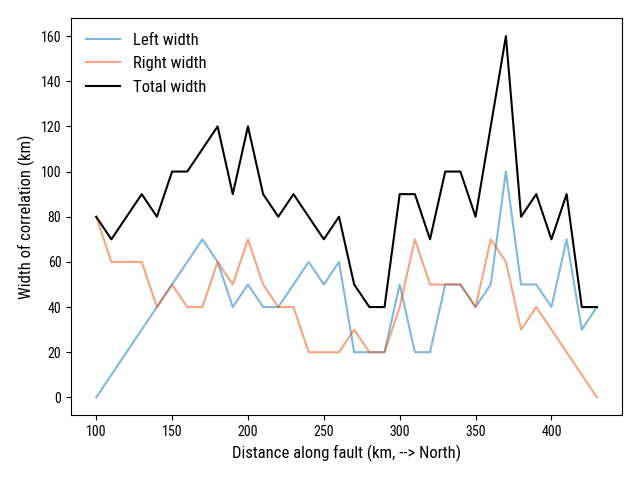

In [24]:
# Instead of fitting, just look how far you are above a threshold
threshold_cc = .07
left_width = []
right_width = []

for ii in range(len(x_bin_edges)-1):
    # Look right
    jj = ii
    while (jj < len(x_bin_edges)-1) and (cc_matrix[ii, jj] > threshold_cc):
        jj += 1
    right_width.append(x_bin_edges[jj-1] - x_bin_edges[ii])

    # Look left
    jj = ii
    while (jj >= 0) and (cc_matrix[ii, jj] > threshold_cc):
        jj -= 1
    left_width.append(x_bin_edges[ii] - x_bin_edges[jj+1])

left_width = np.array(left_width).astype(float)
right_width = np.array(right_width).astype(float)

# Remove wrong points
left_width[~np.any(counts, axis=1)] = np.nan
right_width[~np.any(counts, axis=1)] = np.nan

corr_length = np.array(left_width) + np.array(right_width)

# Show results
fig, ax = plt.subplots()
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Width of correlation (km)')
ax.plot(x_bin_edges[:-1], left_width, '-', label='Left width', alpha=0.5)
ax.plot(x_bin_edges[:-1], right_width, '-', label='Right width', alpha=0.5)
ax.plot(x_bin_edges[:-1], corr_length, 'k-', label='Total width', ms=8)
ax.legend()
plt.tight_layout()
plt.show()

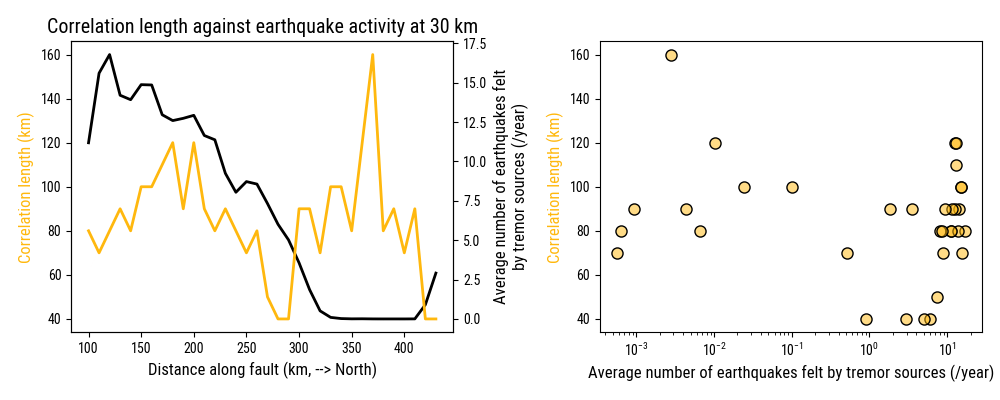

In [25]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

n_close_eq = {}
for dist in dists:
    n_close_eq[dist] = np.zeros(len(x_bin_edges)-1)
    for ii in range(len(x_bin_edges)-1):
        x_min = x_bin_edges[ii]
        x_max = x_bin_edges[ii+1]
        trm_in_bin = trm[trm.xf.between(x_min, x_max)]
        n_close_eq[dist][ii] = np.mean(trm_in_bin[f'n_eq_{dist}km'])

# Plot
chosen_dist = 30
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {chosen_dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes felt\nby tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_close_eq[chosen_dist], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes felt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(n_close_eq[chosen_dist], corr_length, 'o', ms=8, mec='k', mfc=to_rgba('C2', .5))
ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [26]:
# Stats
from scipy.stats import linregress

# Remove nans for the regression
n_eq = n_close_eq[chosen_dist][~np.isnan(corr_length)]
corr_l = corr_length[~np.isnan(corr_length)]

slope, intercept, r_value, p_value, std_err = linregress(n_eq, corr_l)
print('Slope:{:.2f}'.format(slope))
print('Error on slope (std): ±{:.2f}'.format(std_err))
print('Corellation coefficient:{:.2f}'.format(r_value))

SSres = np.sum((corr_l - (slope * n_eq + intercept))**2)  # sum of squares of residuals
SStot = np.sum((corr_l - np.mean(corr_l))**2)  # total sum of squares
R2 = 1 - SSres / SStot
print('Percentage of variance explained (R²): {:.1f}%'.format(100*R2))

Slope:0.30
Error on slope (std): ±0.75
Corellation coefficient:0.07
Percentage of variance explained (R²): 0.5%


In [27]:
# Save results
import pickle
results = {'corr_length': corr_length, 'n_close_eq': n_close_eq, 'dists':dists, 'cc_thr':threshold_cc, 'dx':dx_bin, 'dt': delta}

path = 'results/ak_synch_mc{:.1f}_dx{:d}_cc{:.2f}.pkl'.format(mag_min, int(dx_bin), threshold_cc)
with open(path, 'wb') as f:
    print('Saving results to', path)
    pickle.dump(results, f)

Saving results to results/ak_synch_mc2.4_dx10_cc0.07.pkl
